# Introducing NdGPT-2

This model is GPT-2 from scratch by OpenAI with [NdLinear](https://arxiv.org/abs/2503.17353) from [Ensemble AI](https://ensemblecore.ai/). I used [GPT-3 hyperparameters](https://arxiv.org/abs/2005.14165) for this project. The model is quantized using bfloat16 and tf32.


GPT-2 from OpenAI has 124M parameters, but using NdLinear, I reduced this count to 96M, which is nearly a 25% reduction. I went pretty aggressive on the parameter reduction due to time limit constraints, so I don't expect the model to surpass GPT-2 or GPT-3 in my short run.


I am using [FineWebEDU-10BT](https://huggingface.co/datasets/HuggingFaceFW/fineweb) as the dataset for training, which contains 10 billion tokens of high quality educational data. There was no time to fine tune it on answer/question datasets for an agent.


Every 250 steps, the model is evaluated on the validation dataset and generates 4 samples of text, and that specific model is saved. We also evaluate on the [HellaSwag](https://rowanzellers.com/hellaswag/) benchmark to see how it compares to other models.


After training is done, we print out some statistics to compare it to GPT-2 and GPT-3 models.


Lastly, we prune each model with [Wanda](https://arxiv.org/abs/2306.11695) and compare the number of parameters and one-shot performance on HellaSwag.

## Repo Layout
`experiment` contains the text generation, GPT training, and GPT testing (validation, HellaSwag evaluation), and train/test for a ViT that is not used.


`models` contains GPT-2 from OpenAI, NdGPT-2, ViT, and NdViT. Note that both vision transformers were not used, but the code is there if you are interested in looking.

`pruning` contains the Wanda pruning algorithm code.


`utils` contains utilities for setting a seed, evaluating on HellaSwag, and counting parameters.


## Please Read
Unfortunately, I found the internship application pretty late (about a week ago), so I didn't have time to go full in on this project before the deadline due to courses and research projects, but I would have loved to do more if I had the time. Due to this, I was only able to train NdGPT-2 on half an epoch of the dataset because it would take my computer around ~9 days for a full epoch. However, despite this, the model loss still goes down and the evaluations are on-par with normal GPT-2 for half an epoch. Originally I was going to train both GPT-2 and NdGPT-2 for 1 epoch, but that would take over 2 weeks.


# Training NdGPT-2

In [1]:
from models.gpt2 import GPT2, GPTDataLoader
from config import GPT2Config, TrainConfig
import torch
from experiment.train import train_gpt2
from utils.set_seed import set_seed

# Quantization to use bfloat32
torch.set_float32_matmul_precision('high')

In [2]:
seed = 42
set_seed(seed)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [4]:
# Model and training hyperparameters and parameters
model_config = GPT2Config()
train_config = TrainConfig()

In [5]:
dataset_dir = './data/edu_fineweb10B'

In [6]:
from models.ndgpt2 import NdGPT2
from utils.parameter_count import parameter_count

# B is batch dimension and T is time dimension (sequence)
B = train_config.B
T = train_config.T

trainloader = GPTDataLoader(B=B, T=T, dir_path=dataset_dir)
valloader = GPTDataLoader(B=B, T=T, dir_path=dataset_dir, split='val')

model = NdGPT2(config=model_config)
model = torch.compile(model)
model.eval()
model.to(device=device)
num_params = parameter_count(model)
print(f'Number of parameters for NdGPT-2: {num_params}')

optimizer = torch.optim.AdamW(model.parameters(), lr=train_config.max_lr, fused=True)

trained_model = train_gpt2(model=model,
                           trainloader=trainloader,
                           valloader=valloader,
                           optimizer=optimizer,
                           train_config=train_config)

Number of parameters for NdGPT-2: 96146004
Validation Loss 10.8125
HellaSwag accuracy: 2521/10042 = 0.2510
Step 0 | Loss 10.8222 | lr 0.000003 | Norm 5.1052
Step 1 | Loss 10.7989 | lr 0.000005 | Norm 4.7400
Step 2 | Loss 10.7570 | lr 0.000008 | Norm 3.9013
Step 3 | Loss 10.7137 | lr 0.000010 | Norm 3.1806
Step 4 | Loss 10.6760 | lr 0.000013 | Norm 2.8692
Step 5 | Loss 10.6379 | lr 0.000015 | Norm 2.6597
Step 6 | Loss 10.6045 | lr 0.000018 | Norm 2.4972
Step 7 | Loss 10.5759 | lr 0.000020 | Norm 2.4184
Step 8 | Loss 10.5451 | lr 0.000023 | Norm 2.4302
Step 9 | Loss 10.5214 | lr 0.000025 | Norm 2.3802
Step 10 | Loss 10.4929 | lr 0.000028 | Norm 2.4004
Step 11 | Loss 10.4699 | lr 0.000030 | Norm 2.3703
Step 12 | Loss 10.4449 | lr 0.000033 | Norm 2.3604
Step 13 | Loss 10.4160 | lr 0.000035 | Norm 2.3574
Step 14 | Loss 10.3747 | lr 0.000038 | Norm 2.4107
Step 15 | Loss 10.3420 | lr 0.000040 | Norm 2.4038
Step 16 | Loss 10.3110 | lr 0.000043 | Norm 2.3845
Step 17 | Loss 10.2682 | lr 0.000045

KeyboardInterrupt: 

In [7]:
from models.ndgpt2 import NdGPT2
from utils.parameter_count import parameter_count

checkpoint_dict = torch.load('./checkpoints/ndgpt2_03000.pt', weights_only=False)

model = NdGPT2(config=model_config)
model = torch.compile(model)
model.load_state_dict(checkpoint_dict['model'])
model.eval()
model.to(device=device)
num_params = parameter_count(model)
print(f'Number of parameters for NdGPT-2: {num_params}')


optimizer = torch.optim.AdamW(model.parameters(), lr=train_config.max_lr,fused=True)


trained_model = train_gpt2(model=model,
                           trainloader=trainloader,
                           valloader=valloader,
                           optimizer=optimizer,
                           train_config=train_config)

Number of parameters for NdGPT-2: 96146004
Step 3087 | Loss 6.9655 | lr 0.000578 | Norm 8.9809
Step 3088 | Loss 7.2925 | lr 0.000578 | Norm 4.8804
Step 3089 | Loss 7.0155 | lr 0.000578 | Norm 9.4329
Step 3090 | Loss 7.0025 | lr 0.000578 | Norm 3.5028
Step 3091 | Loss 6.9312 | lr 0.000578 | Norm 7.3091
Step 3092 | Loss 7.0149 | lr 0.000578 | Norm 13.9727
Step 3093 | Loss 7.0561 | lr 0.000578 | Norm 10.5175
Step 3094 | Loss 7.0436 | lr 0.000578 | Norm 6.6744
Step 3095 | Loss 6.9874 | lr 0.000578 | Norm 5.2774
Step 3096 | Loss 6.9221 | lr 0.000578 | Norm 5.2960
Step 3097 | Loss 6.9319 | lr 0.000578 | Norm 3.9716
Step 3098 | Loss 6.8842 | lr 0.000578 | Norm 15.1144
Step 3099 | Loss 6.9520 | lr 0.000578 | Norm 26.0507
Step 3100 | Loss 6.9587 | lr 0.000578 | Norm 8.2713
Step 3101 | Loss 6.8373 | lr 0.000578 | Norm 5.7353
Step 3102 | Loss 6.8856 | lr 0.000578 | Norm 8.8678
Step 3103 | Loss 6.9331 | lr 0.000578 | Norm 12.3079
Step 3104 | Loss 6.8949 | lr 0.000578 | Norm 4.4970
Step 3105 | Loss

KeyboardInterrupt: 

# NdGPT-2 Experiment Results

For the two cells above, you can scroll up to see the steps and losses. At every 250th iteration, the program prints out the validation loss, HellaSwag accuracy, and generates 4 samples. For example on step `9500`, the program shows

```
Validation Loss 4.5625


HellaSwag accuracy: 2474/10042 = 0.2464


Sample 0: This is my machine learning project for the EnsembleAI internship application. Should they hire me?
- Do you have got an assignment about any business plan in
Sample 1: This is my machine learning project for the EnsembleAI internship application. Should they hire me? These people are designed in the future budget. They look, as
Sample 2: This is my machine learning project for the EnsembleAI internship application. Should they hire me? The students on the workshop: if we are talking on the learning
Sample 3: This is my machine learning project for the EnsembleAI internship application. Should they hire me?
As the first thing in this unit will cover the performance of
```


I am printing out 64 tokens for these sample text generations. As we can see, the model is getting coherent, and if you scroll through the entire training steps, you see that the model is definintely learning.


We can compare the sample text generation to the `250`th step.


```
Sample 0: This is my machine learning project for the EnsembleAI internship application. Should they hire me?
Thecra. He’s in the Ba
Sample 1: This is my machine learning project for the EnsembleAI internship application. Should they hire me?StS. It is a one. It makes you were
Sample 2: This is my machine learning project for the EnsembleAI internship application. Should they hire me? The-The4. These types to the other water of his
Sample 3: This is my machine learning project for the EnsembleAI internship application. Should they hire me?
S.
The"
For a family.
An
```

The model started out incoherent.

The hope was to get the model to answer that Ensemble AI should hire me. 😊


## Graphs 
In the cell below, we graph the train/val loss and the HellaSwag accuracy, as compared to GPT-2 (124M) and GPT-3 (124M).

We see that the training loss is going down and converging towards the GPT-2 (124M) loss. As stated earlier, due to the unfortunate circumstances of not having enough time to fully train and tune the hyperparameters, NdGPT-2 was only trained for half an epoch on a much, much smaller dataset compared to OpenAI GPT-2 (124M). However, we still see that the NdGPT-2, despite having ~28M less parameters, it is still converging towards GPT-2. Note that the OpenAI models are fully trained on their massive datasets.


The HellaSwag accuracy, on the right, shows that the model is oscillating between 24 and 26. This is standard, as we should not expect half an epoch to give higher results than GPT-2, which has 29. The highest NdGPT-2 achieved was 25, which was getting there. As time went on, and more epochs were trained, this model would definitely achieve greater results than OpenAI GPT-2, and possibly GPT-3.

Futher training and hyperparemter tuning would be required for this.

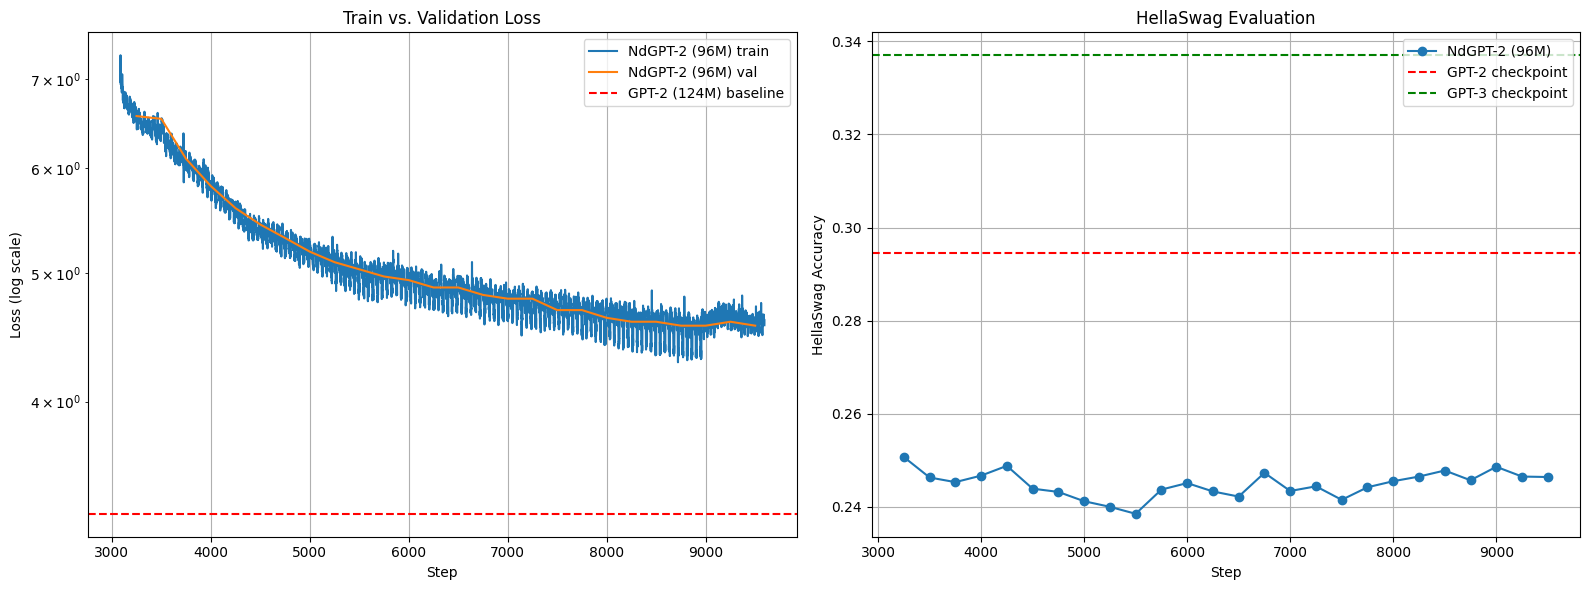

Min train loss: 4.281954
Min  val loss: 4.5625
Max HellaSwag: 0.2507


In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {"124M": 3.2924}[sz]
hella2_baseline = {"124M": 0.294463,
                   "350M": 0.375224,
                   "774M": 0.431986,
                   "1558M": 0.488946}[sz]
hella3_baseline = {"124M": 0.337,
                   "350M": 0.436,
                   "774M": 0.510,
                   "1558M": 0.547}[sz]

streams = {}
with open("logs/ndgpt2-log.txt") as f:
    for line in f:
        step_s, stream, val_s = line.strip().split()
        step, val = int(step_s), float(val_s)
        name = "hellaswag" if stream.lower().startswith("hella") else stream
        streams.setdefault(name, {})[step] = val

streams_xy = { 
    name: zip(*sorted(m.items())) 
    for name, m in streams.items() 
}

x_train, y_train = streams_xy["train"]
x_val,   y_val   = streams_xy["val"]
x_hella, y_hella = streams_xy.get("hellaswag", ([],[]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(x_train, y_train, label=f"NdGPT-2 (96M) train")
ax1.plot(x_val,   y_val,   label=f"NdGPT-2 (96M) val")
ax1.axhline(loss_baseline, color="r", linestyle="--",
            label=f"GPT-2 ({sz}) baseline")
ax1.set_yscale("log")
ax1.set_xlabel("Step")
ax1.set_ylabel("Loss (log scale)")
ax1.set_title("Train vs. Validation Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(x_hella, y_hella, marker="o", label=f"NdGPT-2 (96M)")    
ax2.axhline(hella2_baseline, color="r", linestyle="--", label="GPT-2 checkpoint")
ax2.axhline(hella3_baseline, color="g", linestyle="--", label="GPT-3 checkpoint")
ax2.set_xlabel("Step")
ax2.set_ylabel("HellaSwag Accuracy")
ax2.set_title("HellaSwag Evaluation")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Min train loss:", np.min(y_train))
print("Min  val loss:", np.min(y_val))
print("Max HellaSwag:", np.max(y_hella))

# Pruning
Although I mention pruning in the introduction, I saw no reason to actually prune this model and show results since the model was not converged and pruning it would not do much other than make it worse. However, the `pruning` directory contains the [Wanda algorithm](https://arxiv.org/abs/2306.11695) from scratch.

In `wanda.py` I implemented the algorithm from the paper and also included pruning of the NdLinear layer for Wanda.

# Future Work
Given that NdGPT-2 is a smaller model, using different hyperparameters would be needed, especially for converging faster. Due to time constraints, I didn't have time to play around with hyperparameter tuning, and opted to use GPT-3 hyperparameters.


I am quite confident that with good hyperparameter tuning and more training, this model could surpass both GPT-2 and GPT-3 even though it contains ~28M less parameters.